In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Thử sinh ảnh bị mờ do chuyển động bằng motion blur

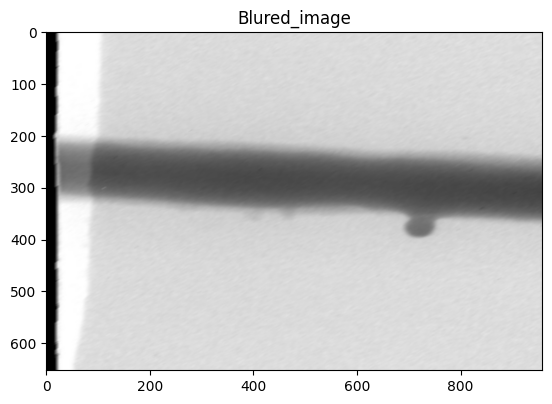

True

In [ ]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

def applyMotionBlur(input_image, length, angle):
    # Tạo kernel mô phỏng hiệu ứng mờ do chuyển động
    EPS = np.finfo(float).eps
    alpha = (angle - math.floor(angle / 180) * 180) / 180 * math.pi
    cosalpha = math.cos(alpha)
    sinalpha = math.sin(alpha)
    if cosalpha < 0:
        xsign = -1
    elif angle == 90:
        xsign = 0
    else:
        xsign = 1
    psfwdt = 1
    sx = int(math.fabs(length * cosalpha + psfwdt * xsign - length * EPS))
    sy = int(math.fabs(length * sinalpha + psfwdt - length * EPS))
    psf1 = np.zeros((sy, sx))
    for i in range(0, sy):
        for j in range(0, sx):
            psf1[i][j] = i * math.fabs(cosalpha) - j * sinalpha
            rad = math.sqrt(i * i + j * j)
            psf1[i][j] = psfwdt + EPS - math.fabs(psf1[i][j])
            if psf1[i][j] < 0:
                psf1[i][j] = 0

    anchor = (0, 0)
    if angle < 90 and angle > 0:
        psf1 = np.fliplr(psf1)
        anchor = (psf1.shape[1] - 1, 0)
    elif angle > -90 and angle < 0:
        psf1 = np.flipud(psf1)
        psf1 = np.fliplr(psf1)
        anchor = (psf1.shape[1] - 1, psf1.shape[0] - 1)
    elif angle < -90:
        psf1 = np.flipud(psf1)
        anchor = (0, psf1.shape[0] - 1)
    psf1 = psf1 / psf1.sum()

    # Áp dụng kernel vào hình ảnh đầu vào
    result = cv2.filter2D(input_image, -1, psf1, anchor=anchor)

    return result


# Đọc hình ảnh đầu vào hoặc tạo một hình ảnh mẫu
input_image = cv2.imread('/content/drive/MyDrive/Project/steel_weld_tube/train/images/overlap052.jpg')  # Thay 'your_input_image.jpg' bằng tên tệp hình ảnh của bạn
if input_image is None:
    # Tạo một hình ảnh mẫu nếu không có hình ảnh đầu vào
    input_image = np.zeros((512, 512, 3), dtype=np.uint8)

# Thiết lập thông số mô phỏng hiệu ứng mờ do chuyển động
length = 10  # Độ dài của kernel
angle = 30  # Góc chuyển động

# Áp dụng hiệu ứng mờ do chuyển động vào hình ảnh
output_image = applyMotionBlur(input_image, length, angle)

# Hiển thị hình ảnh kết quả hoặc lưu nó vào tệp
plt.imshow(output_image)

# Add a title (optional)
plt.title('Blured_image')

# Turn off axis labels (optional)
plt.axis('on')

# Show the image
plt.show()

# Để lưu hình ảnh kết quả:
cv2.imwrite('/content/overlap_motion_blur.jpg', output_image)


Tìm hough line và deblur cho ảnh

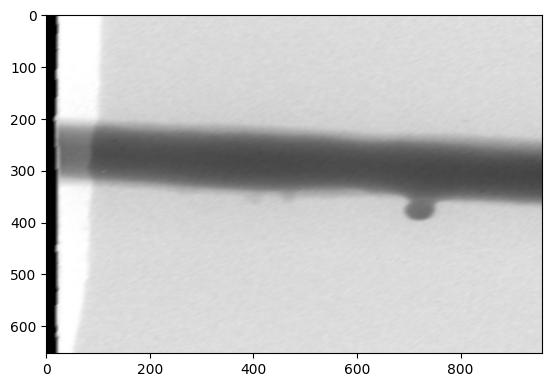

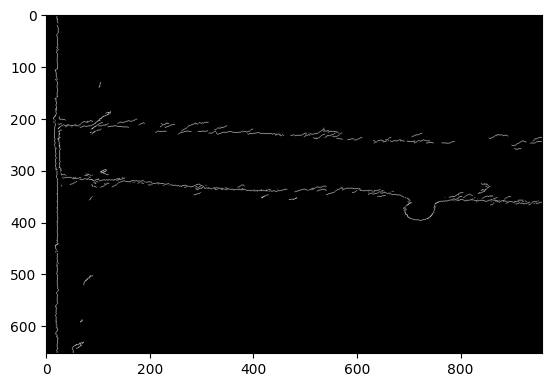

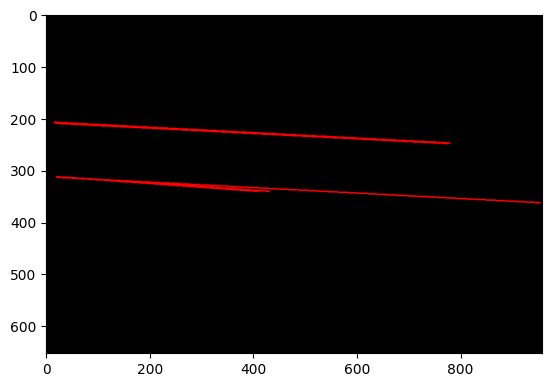

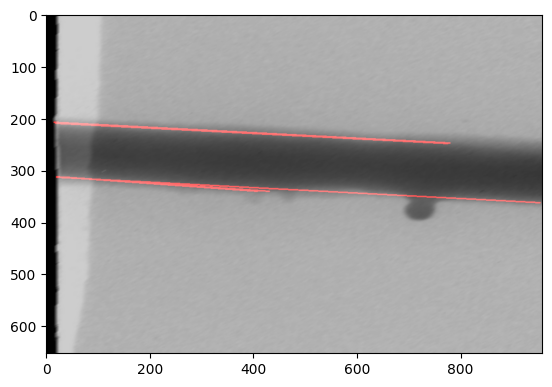

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


def plotImg(img):
    if len(img.shape) == 3:
        img = img[:, :, (2, 1, 0)]
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.show()


image = cv2.imread('/content/overlap_motion_blur.jpg')
plotImg(image)


def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 0, 40)
    return canny


lane_image = np.copy(image)
canny = canny(lane_image)
plotImg(canny)


def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            if np.abs(x1-x2)>30:
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return line_image


lines = cv2.HoughLinesP(canny, rho=1.0, theta=np.pi / 180,threshold=100, minLineLength=2, maxLineGap=200)
line_image = display_lines(image, lines)
plotImg(line_image)

combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
cv2.imwrite('overlap_motion_blur_line.jpg',combo_image)
plotImg(combo_image)

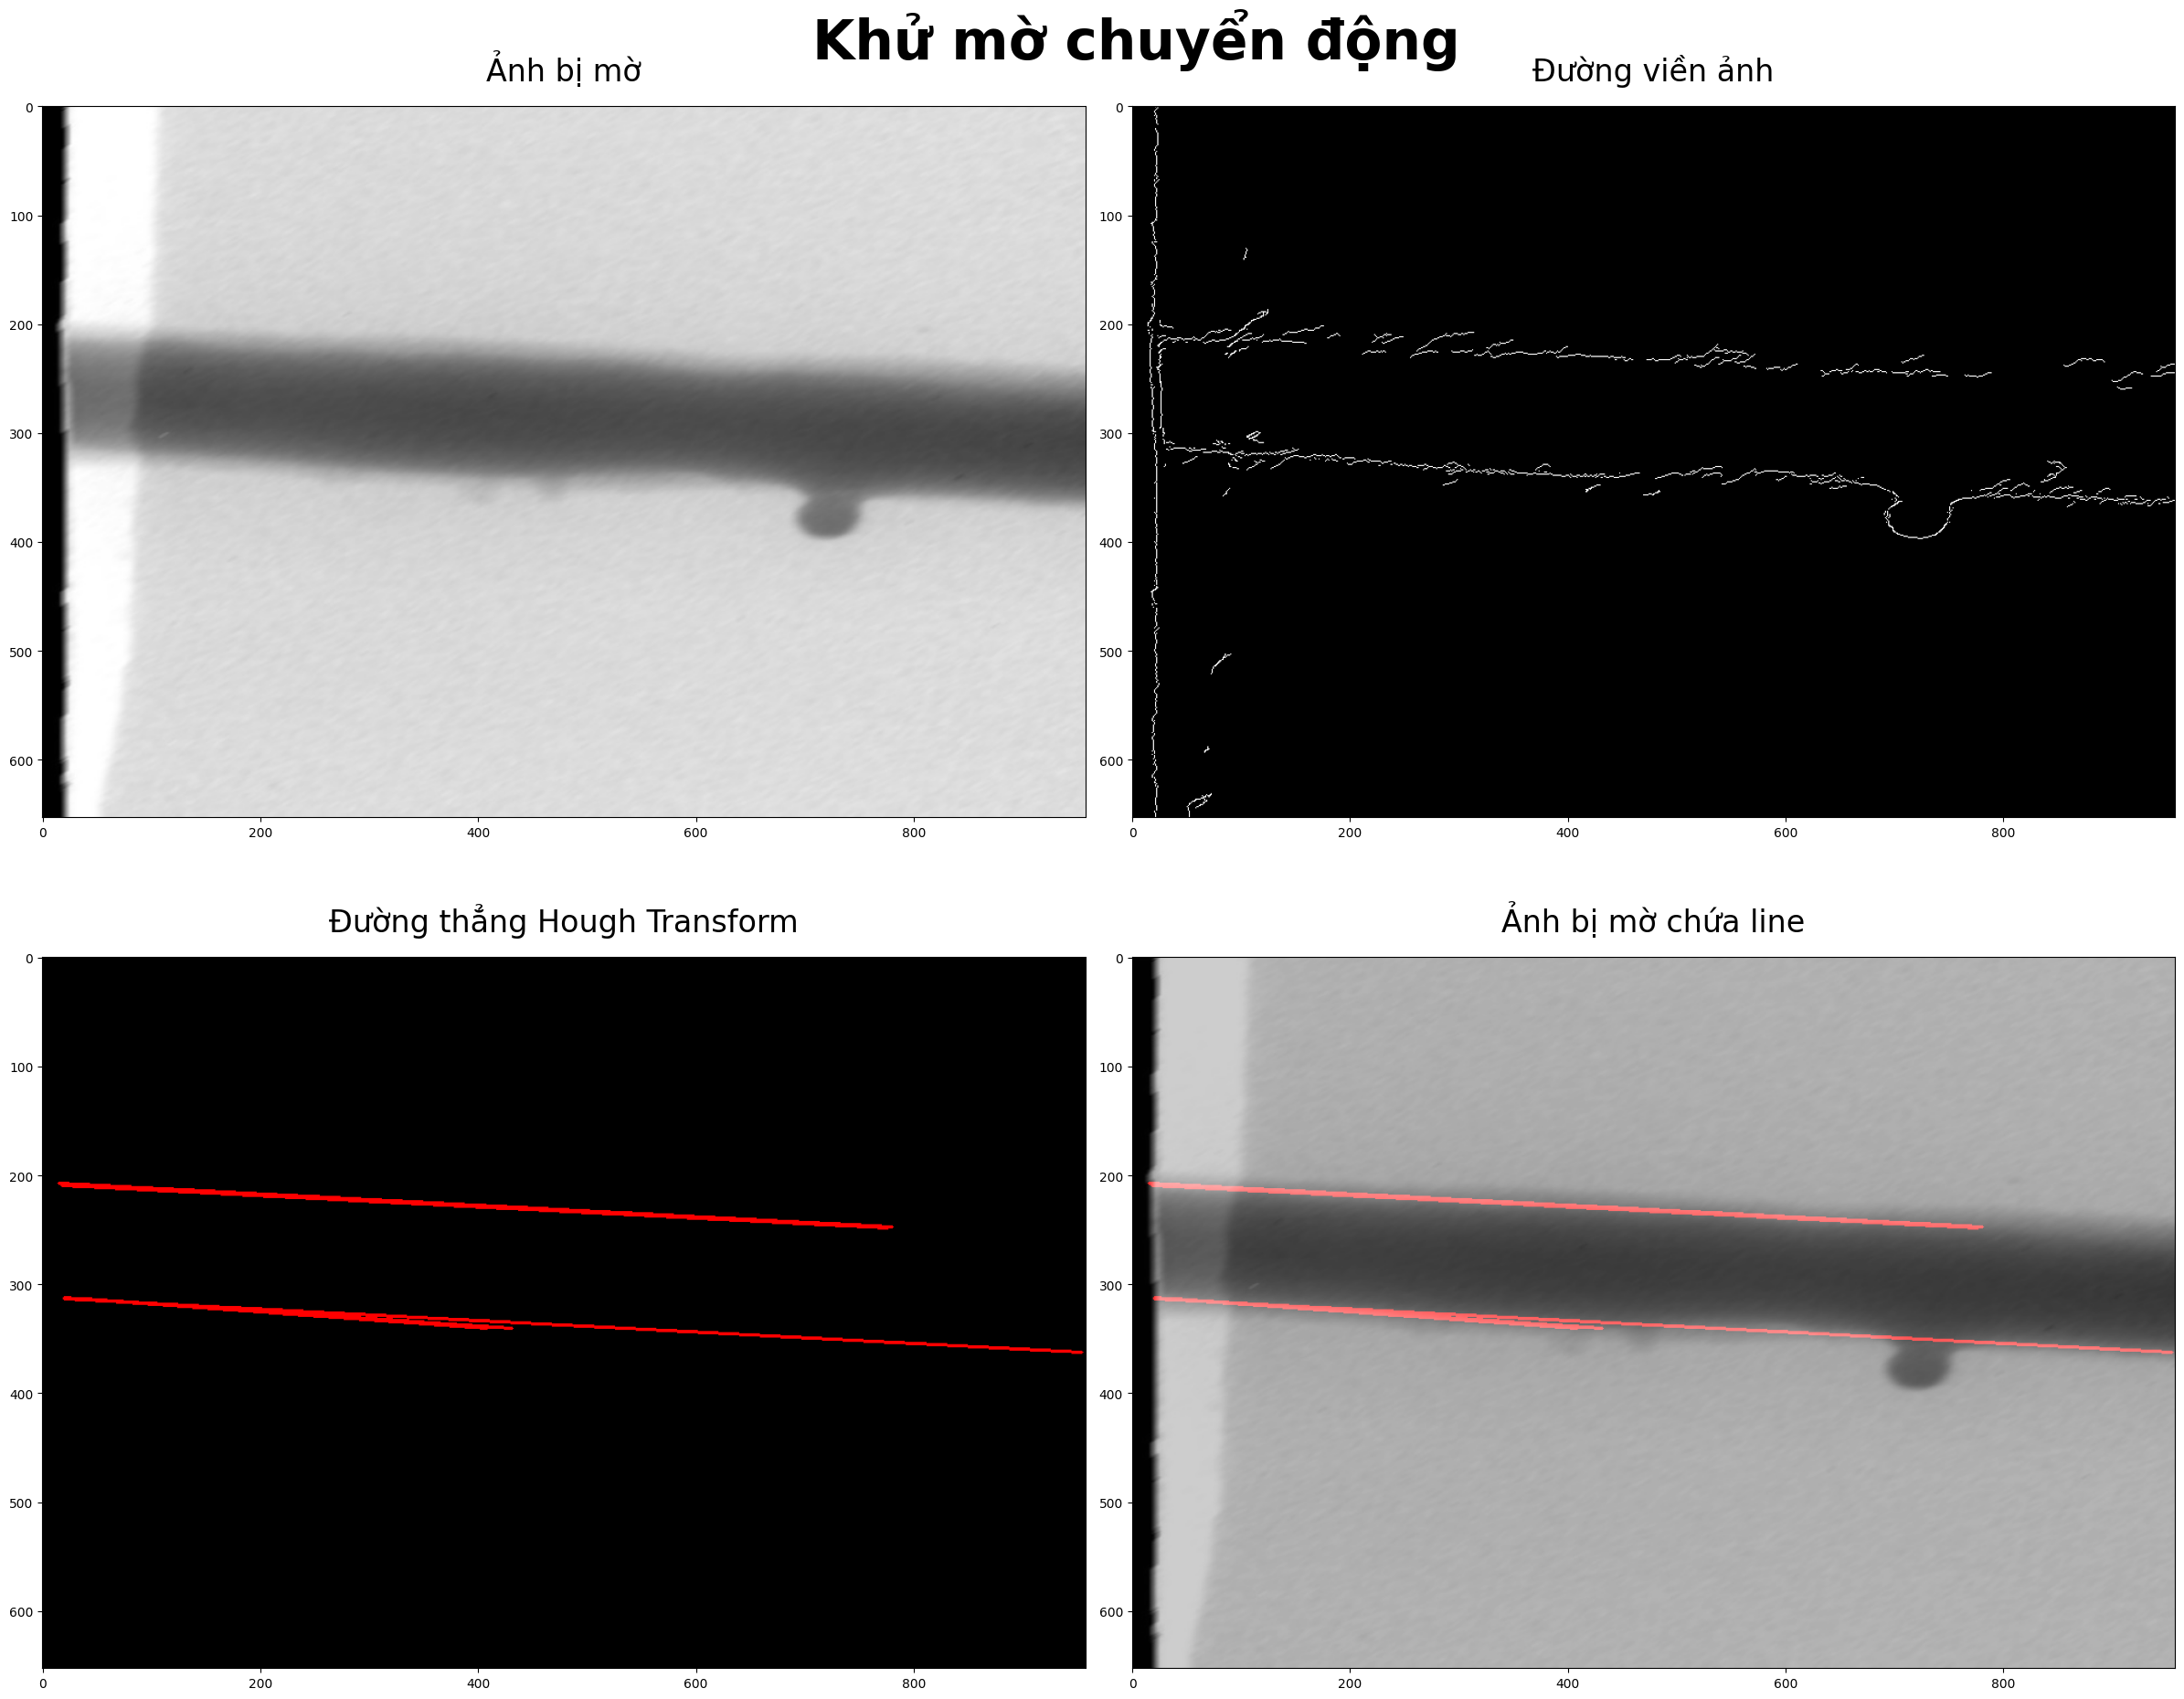

In [ ]:
plt.figure(figsize=(24,20))

plt.suptitle("Khử mờ chuyển động", fontsize=43,x=0.52, y=0.96, weight ='bold')
image_name = ["Ảnh bị mờ", "Đường viền ảnh", "Đường thẳng Hough Transform", "Ảnh bị mờ chứa line"]

plt.subplot(221)
plt.title(image_name[0],fontdict={'weight':'normal','size': 24}, pad =20)
plt.imshow(image)

plt.subplot(222)
plt.title(image_name[1],fontdict={'weight':'normal','size': 24}, pad =20)
plt.imshow(canny,cmap='gray')

plt.subplot(223)
plt.title(image_name[2],fontdict={'weight':'normal','size': 24}, pad =20)
img = line_image[:, :, (2, 1, 0)]
plt.imshow(img)

plt.subplot(224)
plt.title(image_name[3],fontdict={'weight':'normal','size': 24}, pad =20)
img1 = combo_image[:, :, (2, 1, 0)]
plt.imshow(img1)
plt.savefig(fname="/content/drive/MyDrive/Project/HoughTransform.jpg",format="jpg")
plt.tight_layout()
plt.show()

In [ ]:
def get_image_and_label(image_path, label_path):

  with open(label_path, "r") as label_file:
    lines = label_file.readlines()
    labels =[]
    for line in lines:
        data = line.strip().split()
        if len(data) == 5:  # Đảm bảo dòng có đúng định dạng (class x_center y_center width height)
            # Tính tọa độ ban đầu của bndbox trước khi resize bỏi
            class_id = int(data[0])
            x_center = float(data[1]) * image.shape[1]
            y_center = float(data[2]) * image.shape[0]
            width = float(data[3]) * image.shape[1]
            height = float(data[4]) * image.shape[0]

            # Tính toạ độ góc trái trên và góc phải dưới của bounding box
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            labels.append({'class_id': class_id, 'xmin': x1, 'ymin': y1, 'xmax': x2, 'ymax': y2})

  return cv2.imread(image_path), labels



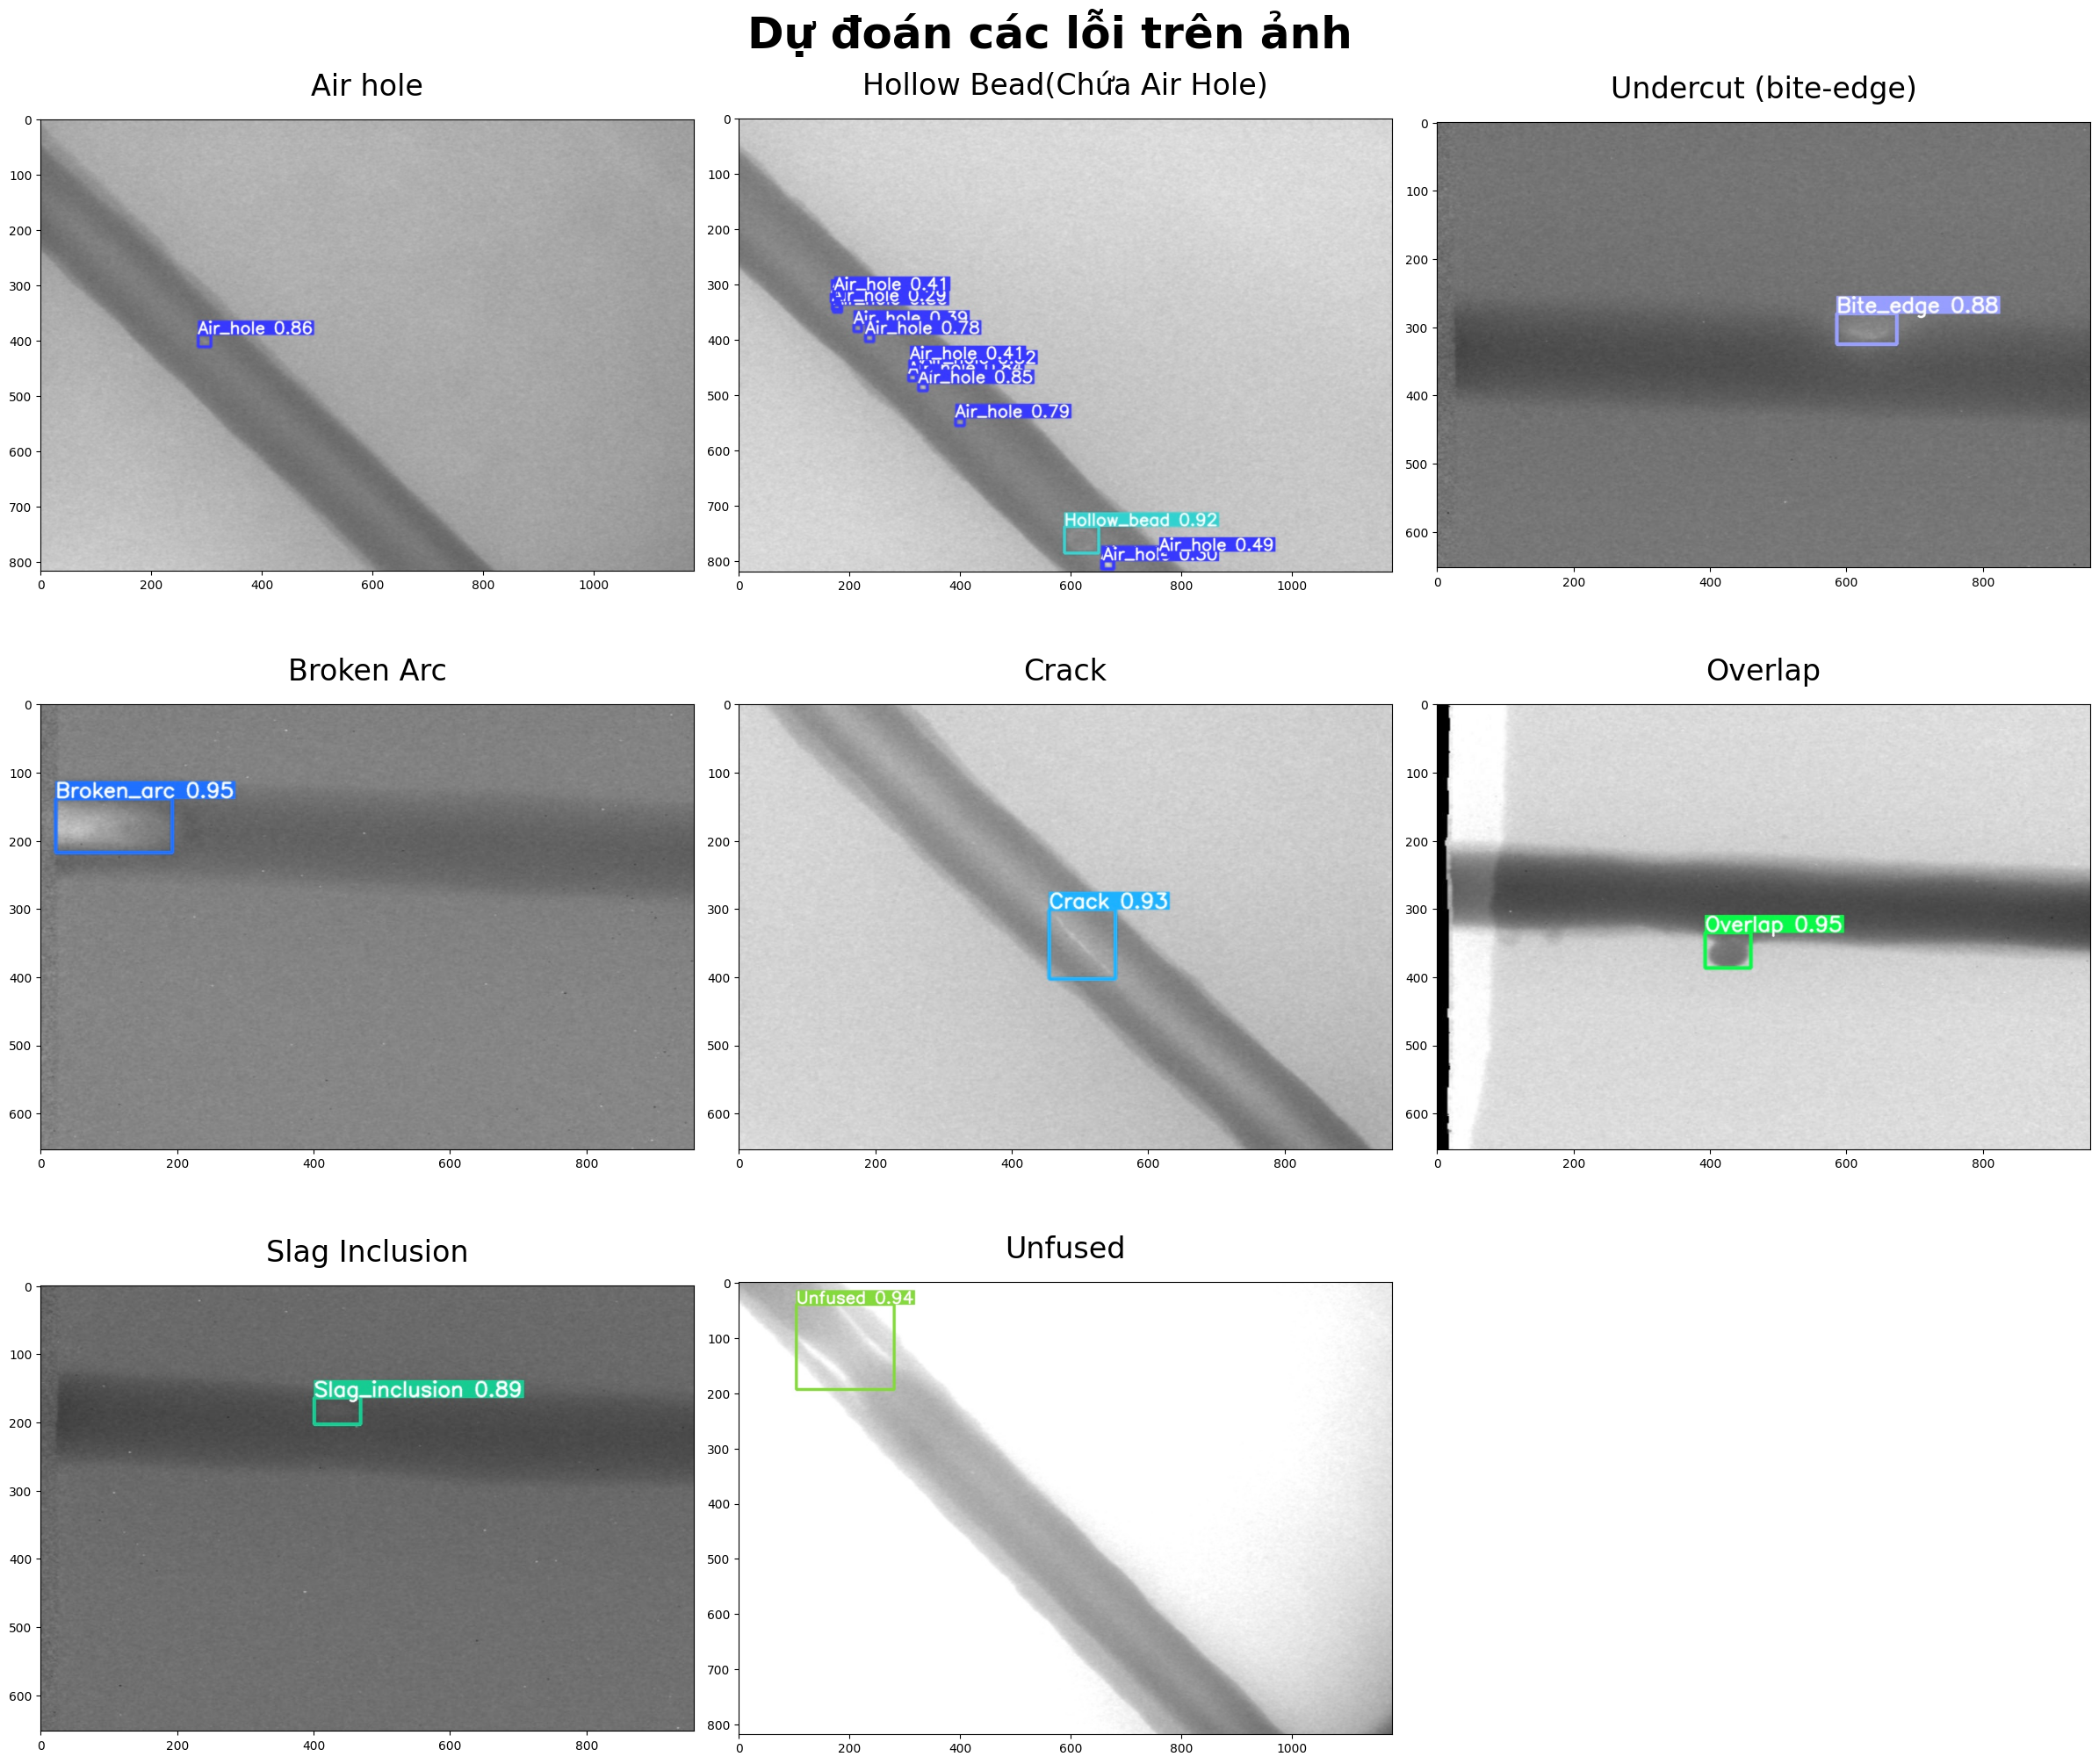

In [ ]:
plt.figure(figsize=(24,21))
image_dir = '/content/drive/MyDrive/Project/yolov5/runs/detect/exp8'
count = 0
pos = 331
plt.suptitle("Dự đoán các lỗi trên ảnh", fontsize=36, y=0.98, weight ='bold')
image_name = ["Air hole","Hollow Bead(Chứa Air Hole)","Undercut (bite-edge)", "Broken Arc", "Crack", "Overlap", "Slag Inclusion","Unfused"]
image_paths = sorted(os.listdir(image_dir))
for image_path in image_paths:
  image_path = os.path.join(image_dir, image_path)
  image = cv2.imread(image_path)
  plt.subplot(pos)
  plt.title(image_name[count],fontdict={'weight':'normal','size': 24}, pad =20)
  plt.imshow(image)
  count+=1
  pos+=1
plt.savefig(fname="/content/drive/MyDrive/Project/predicting.jpg",format="jpg")
plt.tight_layout()

plt.show()
